# Tâche #1 : Classification d'incidents avec un réseau *feedforward* et des *embeddings* Spacy

On reprend la classification des descriptions d’accidents du premier travail. Le corpus de textes contient 3 partitions : 
-	un fichier d’entraînement -  data/incidents_train.json
-	un fichier de validation -  data/incidents_dev.json
-	un fichier de test - data/incidents_test.json

Entraînez un modèle de réseau de neurones de type feedforward multicouche (MLP) avec plongements de mots pour déterminer le type d’un incident à partir de sa description. 

Voici les consignes pour cette tâche : 

-	Nom du notebook : mlp.ipynb
-	Tokenisation : Utilisation de Spacy. 
-	Plongements de mots : Ceux de Spacy. 
-	Normalisation : Aucune normalisation. 
-	Agrégation des plongements de mots : Comparer les approches max, average et min pooling. 
-	Structure du réseau : 1 seule couche cachée dont vous choisirez la taille (à expliquer). 
-	Présentez clairement vos résultats et faites-en l’analyse. En cas de doute, inspirez-vous de ce qui a été fait dans le travail pratique #1. 

Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexes. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code. 
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si non trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc. 
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle. 

## 1. Création du jeu de données (*dataset*)

In [108]:
import json
import spacy
import torch

import numpy as np
from torch import nn
from torch import cuda
from sklearn.feature_extraction.text import CountVectorizer

from torch.utils.data import Dataset, DataLoader
from torch import FloatTensor, LongTensor
from typing import List

from poutyne.framework import Experiment
from poutyne import set_seeds
from torch.optim import SGD
from torch.nn.functional import softmax

from PIL import Image
import matplotlib.pyplot as plt

In [109]:
nlp = spacy.load('en_core_web_md')
train_json = "./data/incidents_train.json"
test_json = "./data/incidents_test.json"
validation_json = "./data/incidents_dev.json"

def load_incident_dataset(filename):
    with open(filename, 'r') as fp:
        incident_list = json.load(fp)
    return incident_list

train_list = load_incident_dataset(train_json)
test_list = load_incident_dataset(test_json)
validation_list = load_incident_dataset(validation_json)
print("Nombre d'incidents d'entrainement:", len(train_list))
print("Nombre d'incidents de test:", len(test_list))
print("Nombre d'incidents de validation:", len(validation_list))
print("\nUn exemple:\n", train_list[10])
print("\nSon étiquette:", train_list[10]["label"])

train_texts= [el["text"] for el in train_list]
train_targets=[int(el["label"]) for el in train_list]
test_texts=[el["text"]  for el in test_list]
test_targets=[int(el["label"]) for el in test_list]
validation_texts=[el["text"]  for el in validation_list]
validation_targets=[int(el["label"]) for el in validation_list]


Nombre d'incidents d'entrainement: 2475
Nombre d'incidents de test: 531
Nombre d'incidents de validation: 531

Un exemple:
 {'text': " At approximately 12:15 p.m. on February 8  2011  Employee # 1 and four other  coworkers were working in the West storage Facility at Enterprise Products  located at Mont Belvieu  Texas. A major fire began but Employee # 1 wasn't  able to escape. The recovery effort was delayed until the evening of February  10  2011  due to the presence of hydrocarbon vapors and small residual fires.   ", 'label': '6'}

Son étiquette: 6


## 2. Gestion de plongements de mots (*embeddings*)

In [110]:
def average_embedding(sentence, nlp_model=nlp):
    tokenised_sentence = nlp_model(sentence)  # tokenized
    nb_column = len(tokenised_sentence)
    nb_rows =  nlp_model.vocab.vectors_length
    sentence_embedding_matrix = np.zeros((nb_rows, nb_column))                                  
    for index, token in enumerate(tokenised_sentence):
        sentence_embedding_matrix[:, index] = token.vector
    return np.average(sentence_embedding_matrix, axis=1)

def maxpool_embedding(sentence, nlp_model=nlp): 
    tokenised_sentence = nlp_model(sentence)
    nb_column = len(tokenised_sentence)
    nb_rows =  nlp_model.vocab.vectors_length 
    sentence_embedding_matrix = np.zeros((nb_rows, nb_column))                                    
    for index, token in enumerate(tokenised_sentence):
        sentence_embedding_matrix[:, index] = token.vector
    return np.max(sentence_embedding_matrix, axis=1)

def minpool_embedding(sentence, nlp_model=nlp): 
    tokenised_sentence = nlp_model(sentence)
    nb_column = len(tokenised_sentence)
    nb_rows =  nlp_model.vocab.vectors_length 
    sentence_embedding_matrix = np.zeros((nb_rows, nb_column))                                    
    for index, token in enumerate(tokenised_sentence):
        sentence_embedding_matrix[:, index] = token.vector
    return np.min(sentence_embedding_matrix, axis=1)

def GetEmbeddings(data, embeddingType = 0):
    embeddings = {}
    for sample_text in train_list:
        tokens = nlp(sample_text['text'])
        for token in tokens:
            embeddings[token.text] = token.vector
    return embeddings

In [111]:
class SpacyDataset(Dataset):
    def __init__(self, dataset: List[str] , target: np.array, sentence_aggregation_function):
        self.dataset = dataset
        self.doc_embeddings = [None for _ in range(len(dataset))]
        self.sentence_aggregation_function = sentence_aggregation_function 
        self.target = target
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if self.doc_embeddings[index] is None:
            self.doc_embeddings[index] = self.sentence_aggregation_function(self.dataset[index])  
        return FloatTensor(self.doc_embeddings[index]), LongTensor([self.target[index]]).squeeze(0)

In [112]:
# Un dictionnaire pour choisir le type d'agrégation
aggregation = {
    "average" : average_embedding,
    "maxpool" : maxpool_embedding,
    "min" : minpool_embedding
}

# On détermine ici comment la classe SpacyDataset construit la représentation d'un texte
# par l'agrégation des représentations de mots. 
# Choix possibles: "average", "maxpool", "min"
aggregation_function = average_embedding
def get_datasets_and_dataloaders(aggregation_type):
    global aggregation_function 
    aggregation_function = aggregation[aggregation_type]  

    # On finalise la construction des 3 jeux de données et leurs dataloaders
    train_dataset = SpacyDataset(train_texts, train_targets, aggregation_function)
    validation_dataset = SpacyDataset(validation_texts, validation_targets, aggregation_function)
    test_dataset = SpacyDataset(test_texts, test_targets, aggregation_function) # à changer

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    return train_dataset, validation_dataset, test_dataset, train_dataloader, validation_dataloader, test_dataloader

## 3. Création de modèle(s)

In [113]:
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self, input_size, hidden_layer_size, output_size) :
        super().__init__()
        self.intput_layer = nn.Linear(input_size, hidden_layer_size)
        self.output_layer = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        x = self.intput_layer(x)
        x = nn.functional.relu_(x)
        x = self.output_layer(x)
        return x

class SingleLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()  
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

## 4. Fonctions utilitaires

Vous pouvez mettre ici toutes les fonctions qui seront utiles pour les sections suivantes.

## 5. Entraînement de modèle(s)

In [114]:
embedding_size = nlp.meta['vectors']['width'] # La dimension des vecteurs d'embeddings de Spacy
nb_classes = len(sorted(set(train_targets)))  

print("Taille des plongements de Spacy:", embedding_size)
print("Nombre de classes:", nb_classes)

Taille des plongements de Spacy: 300
Nombre de classes: 9


In [115]:
learningRateAverage = 0.005
num_epochAverage = 100
hidden_sizeAverage = 200

learningRateMin = 0.005
num_epochMin = 100
hidden_sizeMin = 200

learningRateMax = 0.005
num_epochMax = 100
hidden_sizeMax = 200

#Création du modèle
set_seeds(42)

#Average
model = SingleLayerPerceptron(embedding_size, hidden_sizeAverage,nb_classes)
optimizer = SGD(model.parameters(), lr=learningRateAverage)
device= 'cuda' if cuda.is_available() else 'cpu'
model.to(device)
train_dataset,validation_dataset,test_dataset,train_dataloader,validation_dataloader,test_dataloader_avg = get_datasets_and_dataloaders("average")
directory_name = 'model/bert/{}_mlp'.format(aggregation_function.__name__)  
experiment = Experiment(directory_name, 
                        model, 
                        optimizer = optimizer, 
                        task="classification")
logging_average = experiment.train(train_dataloader, validation_dataloader, epochs=num_epochAverage, disable_tensorboard=True)

#Max
model = SingleLayerPerceptron(embedding_size, hidden_sizeMax,nb_classes)
optimizer = SGD(model.parameters(), lr=learningRateMax)
device= 'cuda' if cuda.is_available() else 'cpu'
model.to(device)

train_dataset,validation_dataset,test_dataset,train_dataloader,validation_dataloader,test_dataloader_max = get_datasets_and_dataloaders("maxpool")
directory_name = 'model/bert/{}_mlp'.format(aggregation_function.__name__)  
experiment = Experiment(directory_name, 
                        model, 
                        optimizer = optimizer, 
                        task="classification") 
logging_max = experiment.train(train_dataloader, validation_dataloader, epochs=num_epochMax, disable_tensorboard=True)

#Min
model = SingleLayerPerceptron(embedding_size, hidden_sizeMin,nb_classes)
optimizer = SGD(model.parameters(), lr=learningRateMin)
device= 'cuda' if cuda.is_available() else 'cpu'
model.to(device)

train_dataset,validation_dataset,test_dataset,train_dataloader,validation_dataloader,test_dataloader_min = get_datasets_and_dataloaders("min")
directory_name = 'model/bert/{}_mlp'.format(aggregation_function.__name__)  
experiment = Experiment(directory_name, 
                        model, 
                        optimizer = optimizer, 
                        task="classification")
logging_min = experiment.train(train_dataloader, validation_dataloader, epochs=num_epochMin, disable_tensorboard=True)


Epoch:   1/100 Train steps: 78 Val steps: 17 57.78s loss: 1.748313 acc: 38.383838 fscore_macro: 0.061837 val_loss: 1.679800 val_acc: 39.736347 val_fscore_macro: 0.065588
Epoch 1: val_acc improved from -inf to 39.73635, saving file to model/bert/average_embedding_mlp\checkpoint_epoch_1.ckpt
Epoch:   2/100 Train steps: 78 Val steps: 17 0.14s loss: 1.654171 acc: 39.191919 fscore_macro: 0.070403 val_loss: 1.616829 val_acc: 41.431262 val_fscore_macro: 0.092217
Epoch 2: val_acc improved from 39.73635 to 41.43126, saving file to model/bert/average_embedding_mlp\checkpoint_epoch_2.ckpt
Epoch:   3/100 Train steps: 78 Val steps: 17 0.14s loss: 1.613877 acc: 40.606061 fscore_macro: 0.092905 val_loss: 1.609823 val_acc: 47.269303 val_fscore_macro: 0.151398
Epoch 3: val_acc improved from 41.43126 to 47.26930, saving file to model/bert/average_embedding_mlp\checkpoint_epoch_3.ckpt
Epoch:   4/100 Train steps: 78 Val steps: 17 0.14s loss: 1.579372 acc: 42.666667 fscore_macro: 0.120947 val_loss: 1.54247

## 6. Évaluation et analyse de résultats

In [116]:
def get_most_probable_class(sentence, model):
    vectorized_sentence = aggregation_function(sentence)
    prediction = model(FloatTensor(vectorized_sentence).squeeze(0)).detach()
    output = softmax(prediction, dim=0)
    max_category_index = np.argmax(output)
    max_category = train_targets[max_category_index]
    print("\nClassification de la phrase: ", sentence)
    print("Sorties du réseau de neurones:", prediction)
    print("Valeurs obtenues après application de softmax:", output)
    print("Meilleure classe: {} qui correspond en sortie à la neurone {}".format(max_category, max_category_index))
    return(max_category)

In [117]:
#[get_most_probable_class(sentence, model) for sentence in test_texts]

In [118]:
print("Average")
directory_name = 'model/bert/{}_mlp'.format(average_embedding.__name__)
experiment = Experiment(directory_name, 
                        model, 
                        optimizer = optimizer, 
                        task="classification")
log_average=experiment.test(test_dataloader_avg)


Average
Found best checkpoint at epoch: 98
lr: 0.005, loss: 0.802334, acc: 72.3636, fscore_macro: 0.517664, val_loss: 0.966836, val_acc: 69.1149, val_fscore_macro: 0.466368
Loading checkpoint model/bert/average_embedding_mlp\checkpoint_epoch_98.ckpt
Running test
Test steps: 17 8.42s test_loss: 0.959032 test_acc: 67.608286 test_fscore_macro: 0.456511          


In [119]:
print("Max")
directory_name = 'model/bert/{}_mlp'.format(maxpool_embedding.__name__)
experiment = Experiment(directory_name, 
                        model, 
                        optimizer = optimizer, 
                        task = "classification")
log_max = experiment.test(test_dataloader_max)

Max
Found best checkpoint at epoch: 84
lr: 0.005, loss: 1.27131, acc: 53.4949, fscore_macro: 0.400957, val_loss: 1.60514, val_acc: 48.9642, val_fscore_macro: 0.234784
Loading checkpoint model/bert/maxpool_embedding_mlp\checkpoint_epoch_84.ckpt
Running test
Test steps: 17 8.10s test_loss: 1.755377 test_acc: 41.619586 test_fscore_macro: 0.178947          


In [120]:
print("Min")
directory_name = 'model/bert/{}_mlp'.format(minpool_embedding.__name__)
experiment = Experiment(directory_name, 
                        model, 
                        optimizer = optimizer, 
                        task = "classification")
log_min = experiment.test(test_dataloader_min)

Min
Found best checkpoint at epoch: 81
lr: 0.005, loss: 1.19327, acc: 56.202, fscore_macro: 0.427203, val_loss: 1.35359, val_acc: 52.919, val_fscore_macro: 0.307268
Loading checkpoint model/bert/minpool_embedding_mlp\checkpoint_epoch_81.ckpt
Running test
Test steps: 17 8.17s test_loss: 1.487187 test_acc: 52.354049 test_fscore_macro: 0.256985          


In [121]:
import matplotlib.pyplot as plt
import numpy as np

# Trois objets avec les champs spécifiés
data_objects = [
    log_average,
    log_max,
    log_min,
]

def showModelsResult():
    # Champs à comparer
    fields = ['time', 'test_loss', 'test_acc', 'test_fscore_macro']

    # Préparation des données pour le traçage
    data_to_plot = {field: [obj[field] for obj in data_objects] for field in fields}

    # Création du graphique
    fig, axs = plt.subplots(len(fields), figsize=(8, 6))

    # Couleurs différentes pour chaque objet
    colors = ['skyblue', 'lightcoral', 'lightgreen']

    # Barres avec couleurs différentes et texte en gras pour les valeurs maximales
    for i, field in enumerate(fields):
        for j, obj in enumerate(data_objects):
            bar = axs[i].bar(j, data_to_plot[field][j], color=colors[j])
            axs[i].text(j, data_to_plot[field][j], f'{data_to_plot[field][j]:.2f}', ha='center', va='bottom', fontweight='normal')
            if data_to_plot[field][j] == max(data_to_plot[field]):
                bar[0].set_linewidth(2)  # Augmente l'épaisseur de la barre pour la valeur maximale
                bar[0].set_edgecolor('black')  # Bordure noire pour la valeur maximale
                axs[i].text(j, data_to_plot[field][j], f'{data_to_plot[field][j]:.2f}', ha='center', va='bottom', fontweight='bold')

        axs[i].set_ylabel(field)
        axs[i].set_xticks(range(len(data_objects)))
        axs[i].set_xticklabels(["Average", "Max", "Min"])

    plt.tight_layout()
    plt.show()



Avant de lancer l'entrainement des 3 modèles, nous avons du régler certains paramètres d'apprentissages. Nous avons réglé :
- Le nombre d'epoch, c'est à dire le nombre d'itération d'entrainement sur l'ensemble du dataset.
- Le nombre de neurones de la couche cachée.
- L'optimiseur utilisé.
- Le taux d'apprentissage

La taille du batch est paramètré selon l'optimiseur utilisé, nous n'y toucherons pas ici.

Ce modèle de réseau de neurone étant un estimateur universel, il faut en pratique lui donner assez de paramètres pour que l'approximation soit correcte. Mais de plus, il faut l'entrainer
suffissanment pour que le modèle converge.
Ainsi le paramétrage est fait de manière à pouvoir entrainer suffisament nos réseaux avec la puissance de calcul disponible tout en ayant assez de paramètres pour avoir de bon résultat.

Pour choisir l'optimiseur, nous avons que deux choix pertinants: "Adam" et "SGD". Pour connaitre le plus adapté à nos modèles,
nous avons lancé un entrainement sur 25 epochs avec 50 paramètres sur les 3 modèles, et l'optimiseur SGD converge plus vite que Adam, c'est donc celui-ci que nous allons utiliser.

Le taux d'apprentissage (learningRate) correspond à la vitesse de convergeance du modèle, plus il est élevé, plus les poids du modèle vont être modifiés à chaque epoch et ainsi plus le modèle convergera vite. Plus mathématiquement, le taux d'apprentissage est un multiplicateur du gradient de la fonction de perte. Cependant un taux d'apprentissage trop élevé va rendre le modèle non convergeant, ceci se remarque facilement sur le graphique de perte en fonction des epochs, sur un modèle avec le taux d'apprentissage trop élevé, la courbe sera soit anarchique; soit les pertes seront quasiment constante alors que dans l'idéal on cherche à obtenir une exponentielle décroissante. On cherche à obtenir le taux d'apprentissage le plus grand possible; tout en ayant un modèle convergeant.

Nous décideons donc de lancer un petit entrainement sur le modèle Average_Embedding avec 20 epochs et uniquement 30 paramètres pour la couche cachée pour que l'entrainement soit rapide avec des learning rate différentes (5, 1, 0.1, 0.01, 0.001) pour voir lequel est le plus adapté.
Et voici les courbes de pertes obtenues pour les différents taux d'apprentissage.

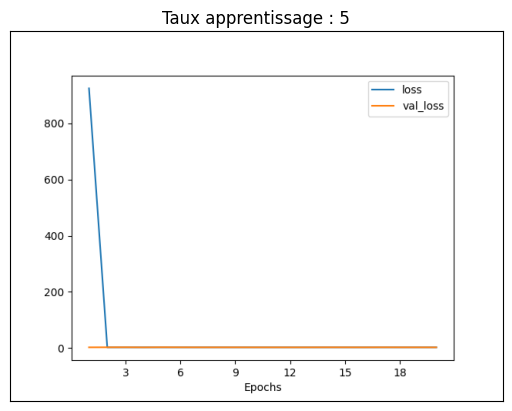

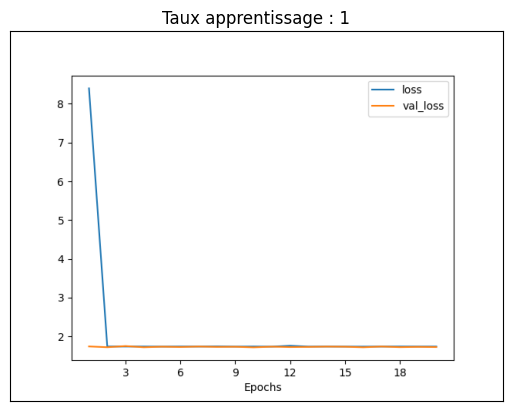

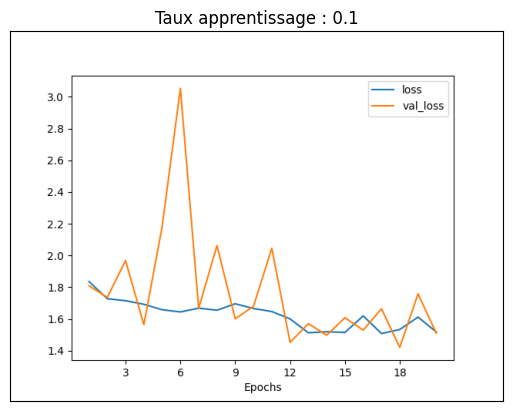

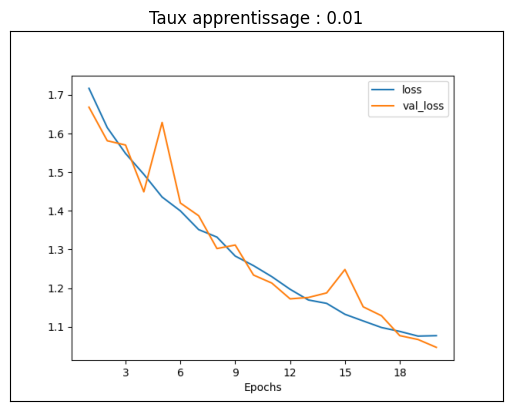

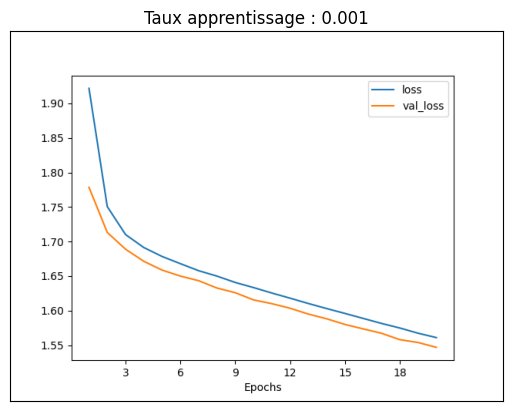

In [122]:
def show(path, title):    
    img = np.asarray(Image.open(path))
    plt.title(title)
    fig = plt.imshow(img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

show('./Analyse/lr/lr5/loss.png', 'Taux apprentissage : 5')
show('./Analyse/lr/lr1/loss.png', 'Taux apprentissage : 1')
show('./Analyse/lr/lr0,1/loss.png', 'Taux apprentissage : 0.1')
show('./Analyse/lr/lr0,01/loss.png','Taux apprentissage : 0.01')
show('./Analyse/lr/lr0,001/loss.png', 'Taux apprentissage : 0.001')

On remarque que un taux d'apprentissage de 5, 1 et 0.1 converge mal, on a des courbes discontinues contrairement avec un taux d'apprentissage de 0.01 ou 0.001 ou l'on obtient des exponentielles décroissantes. La courbe à 0.001 est vraiment très lisse tandis que celle à 0.01 pourrait l'être un peu plus. Nous allons donc prendre un entre 2 et poursuivre nos apprentissage de modèle avec un taux d'apprentissage de 0.05. 

Nous allons ensuite configurer le nombre de paramètres de la couche caché. En effet nous avons une puissance de calcul limité, ainsi pour un même temps d'entrainement, plus on ajoute de paramètres sur la couche cachée, plus on doit diminué le nombre d'epoch car une epoch sur une grande couche est plus longue que sur une petite couche.
De plus il faut assez d'epoch pour que le modèle converge, cependant une fois que le modèle a convergé, rajouter des epochs supplémentaires est inutile car le modèle ne gagnera que très peu en performance.

Notre objectif est donc de trouver le nombre maximum de paramètres de la couche cachée pour que le modèle converge en moins de disons 20 minutes d'entrainement, une durée que nous jugeons raisonable.

On lance donc l'entrainement du modèle average_embedding sur 100, 200, 500, 1000, 3000, et 5000 paramètres pour la couche cachée avec un nombre d'epoch faible (20) pour que l'apprentissage reste rapide. Le but de ces entrainements n'est pas de crée un modèle performant mais de voir si le modèle pourra converger avec un nombre d'epoch raisonnable mais aussi pour vérifier que l'apprentissage n'est pas trop long.

Voici la courbe de précision des modèles d'Average_embedding pour les valeurs de la taille de couche cité précedement : 

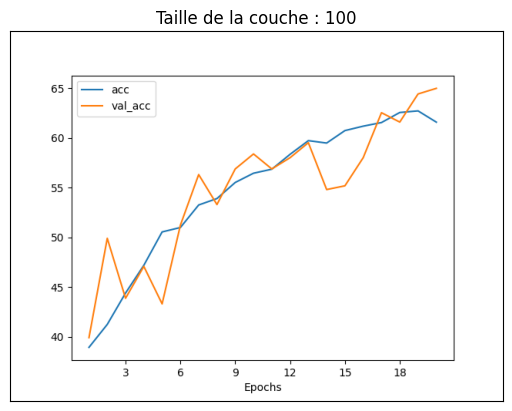

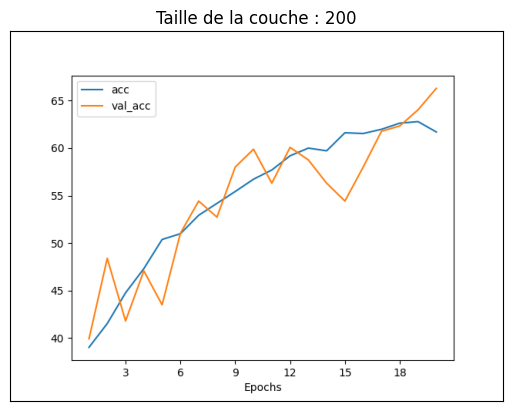

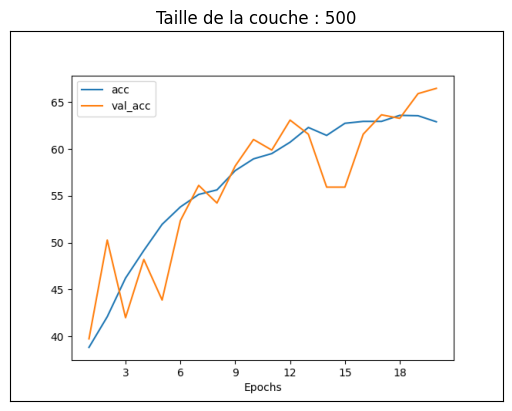

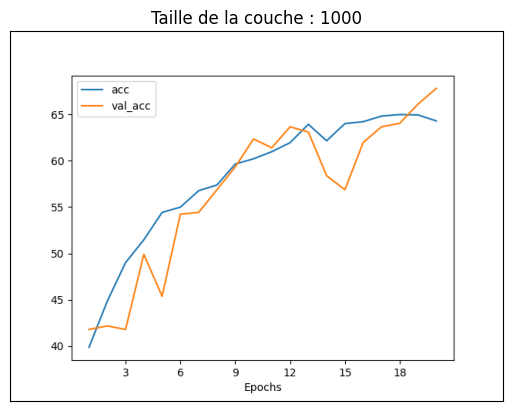

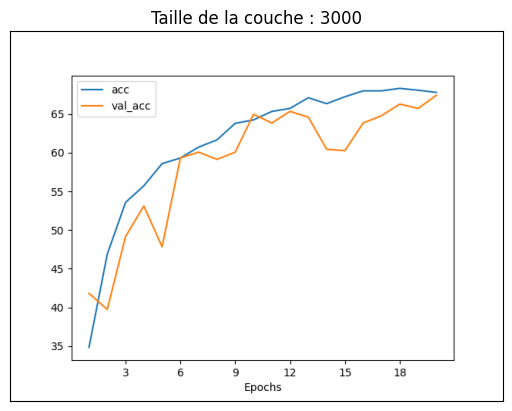

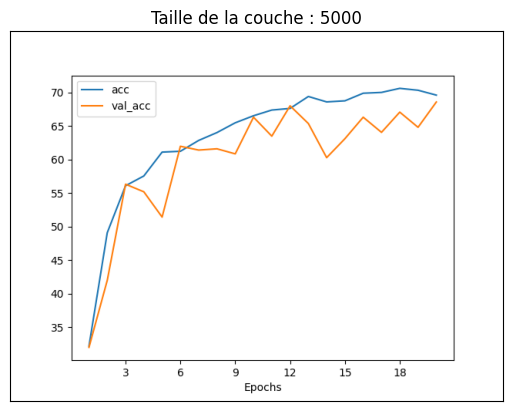

In [123]:
show('./Analyse/size/100/acc.png', 'Taille de la couche : 100')
show('./Analyse/size/200/acc.png', 'Taille de la couche : 200')
show('./Analyse/size/500/acc.png', 'Taille de la couche : 500')
show('./Analyse/size/1000/acc.png', 'Taille de la couche : 1000')
show('./Analyse/size/3000/acc.png', 'Taille de la couche : 3000')
show('./Analyse/size/5000/acc.png', 'Taille de la couche : 5000')

Avec nos machines d'étudiants, l'optimiseur SGD et un taux d'apprentissage de 0.005, tous les modèles converges rapidement sauf celui à 10000 paramètres qui est beaucoup plus long. De plus on remarque qu'augmenter le nombre de paramètres augmente un peu la précision du modèle mais la différence entre le modèle à 200 et 10000 paramètres est assez faible surtout pour les données de validation où c'est pratiquement équivalent. Nous allons toujours prioriser les modèles plus simple aux modèles complexes pour que le modèle généralise au mieux les données. Nous décidons ainsi de prendre 200 comme nombre de paramètres de la couche cachée.

Il est temps de passer au dernier entrainement, ceux qui nous donnerons les meilleurs résultat possible. Pour cela nous allons entrainer nos 3 modèle (Average_embedding, Maxpool et Minpoll) avec un taux d'apprentissage de 0.005, 200 paramètres pour la couche cachée et avec 125 epoch pour que le modèle converge bien sans non plus faire du surentrainement. Je vais supposer ici que les paramètres d'apprentissage optimaux sont les mêmes pour les 3 modèles car ils sont théoriquement assez proche.

Voici les résultats des 3 modèles : 

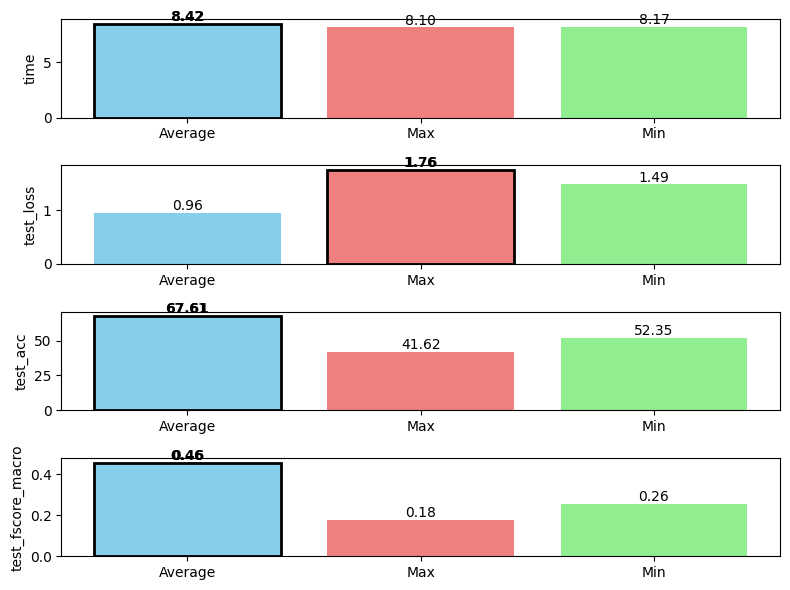

In [124]:
showModelsResult()

On remarque que le modèle de Maxpooling et de Minpooling on des résultats un peu décevant bien que le modèle Minpooling soit un peu meilleur avec une précision de 53% sur les données de test.
Le modèle Average_embedding a une précision de 68% sur les données de test ce qui est plutôt satisfaisant. Peut être qu'il présente de meilleur résultat car le calcul des paramètres d'apprentissage ont été calculé avec ce modèle en particulier.